<a href="https://colab.research.google.com/github/JuanDa14Sa/PageRank/blob/main/PageRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

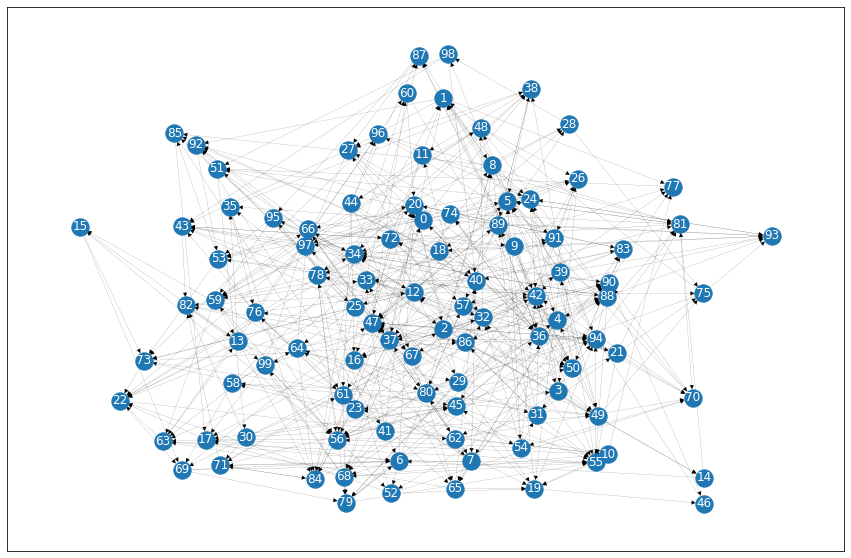

In [ ]:
plt.figure(figsize=(15,10))
# created a directed graph
graph=nx.gnp_random_graph(100, 0.05, directed=True)
#draw a graph
nx.draw_networkx(graph, with_labels=True, width=0.1, arrows=True, font_color='white')
#plot a graph
plt.show()

In [ ]:
adj_matrix = nx.adjacency_matrix(graph).todense().astype(float)
adj_matrix

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def substochastic_mat(adj_matrix):
    k = np.sum(adj_matrix, axis=0)
    substochastic_matrix = np.divide(adj_matrix, k, out=np.zeros_like(adj_matrix), where=k!=0)
    return substochastic_matrix
substochastic_matrix = substochastic_mat(adj_matrix)
substochastic_matrix

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def stochastic_mat(substochastic_matrix):
    stochastic_matrix = substochastic_matrix.copy()
    for i in range(len(substochastic_matrix)):
        if np.sum(substochastic_matrix, axis=0).tolist()[0][i]==0:
            stochastic_matrix[i,:] = 1/len(substochastic_matrix)
    stochastic_matrix /= stochastic_matrix.sum(axis=0)
    return stochastic_matrix
stochastic_matrix = stochastic_mat(substochastic_matrix)
stochastic_matrix

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def google_mat(stochastic_matrix, alpha=0.85): 
    e = np.ones(stochastic_matrix.shape)*(1-alpha)*(1/len(stochastic_matrix))
    google_matrix = stochastic_matrix.copy()
    google_matrix = google_matrix*alpha + e
    return google_matrix
google_matrix = google_mat(stochastic_matrix)
google_matrix

matrix([[0.0015, 0.0015, 0.0015, ..., 0.0015, 0.0015, 0.0015],
        [0.0015, 0.0015, 0.0015, ..., 0.0015, 0.0015, 0.0015],
        [0.0015, 0.0015, 0.0015, ..., 0.0015, 0.0015, 0.0015],
        ...,
        [0.0015, 0.0015, 0.0015, ..., 0.0015, 0.0015, 0.0015],
        [0.0015, 0.0015, 0.0015, ..., 0.0015, 0.0015, 0.0015],
        [0.0015, 0.0015, 0.0015, ..., 0.0015, 0.0015, 0.0015]])

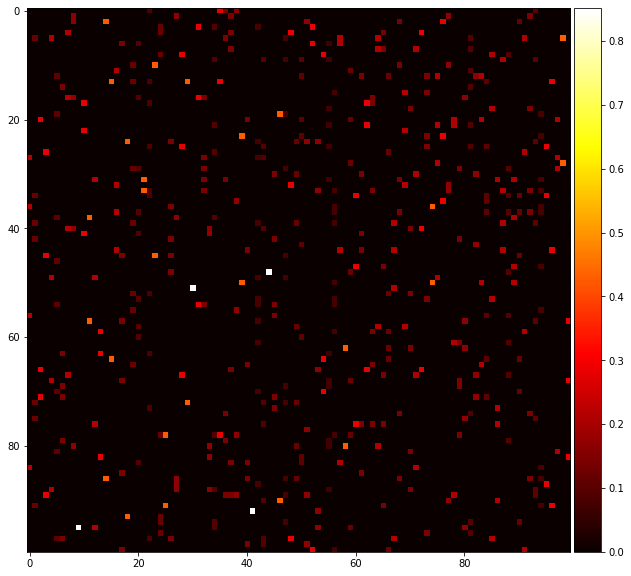

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(15,10))
ax = plt.subplot()
im = ax.imshow(google_matrix, cmap='hot', vmin=0)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

In [ ]:
def dangling_correction(value):
    if value == 0:
        value = 1
    else:
        value = 0
    return value
find_dangling = np.vectorize(dangling_correction)

In [ ]:



tol = 0.001
max_iter = 100
alpha = 0.85
N = len(graph)
# if N == 0:
#     return {}

nodelist = list(graph)
A = nx.adjacency_matrix(graph)
S = A.sum(axis=1)
S = np.divide(1, S, where=S!=0)
# TODO: csr_array
Q = sp.sparse.spdiags(S.T, 0, *A.shape) #diagonal matrix whose entries are the sum row of adj matrix
A = Q @ A

x = np.repeat(1.0 / N, N)


p = np.repeat(1.0 / N, N)
dangling_weights = p
is_dangling = np.where(S == 0)[0] #find dangling nodes

# power iteration: make up to max_iter iterations
for _ in range(max_iter):
    xlast = x
    x = alpha * (x @ A) + (alpha * np.multiply(find_dangling(S).T, x)+1-alpha)/N
    # print(x)
    # check convergence, l1 norm
    err = np.absolute(x - xlast).sum()
    if err < N * tol:
        break
x = np.asarray(x)[0]
page = dict(zip(nodelist, map(float, x)))    
sorted(page.items(), key=lambda x:x[1])

[(9, 0.0022699992160926876),
 (44, 0.002612938533399471),
 (21, 0.002810882728450176),
 (14, 0.0035561122493268146),
 (87, 0.0036078183992346935),
 (29, 0.00366076074239418),
 (15, 0.0038062030505952383),
 (25, 0.003951128030517763),
 (58, 0.004209819709388385),
 (31, 0.00437820414186508),
 (96, 0.0045148534474206345),
 (11, 0.004676920156249999),
 (95, 0.004712436890452486),
 (28, 0.004848682342465632),
 (12, 0.004890790315787195),
 (76, 0.0049041532566846185),
 (98, 0.0049597637589102),
 (41, 0.005329708800429894),
 (75, 0.005478752086502426),
 (48, 0.005552296082136559),
 (35, 0.005578370279195012),
 (16, 0.005581045844618712),
 (39, 0.005624375673894559),
 (52, 0.00594185697420635),
 (72, 0.0063191376611315825),
 (74, 0.0064162452307728645),
 (7, 0.0064494214673485135),
 (99, 0.00646401171186067),
 (23, 0.006677803038194445),
 (32, 0.006709445843529542),
 (62, 0.00673614645447531),
 (78, 0.006803427727176354),
 (64, 0.006838938997871525),
 (2, 0.006895389067426574),
 (80, 0.0074460

In [ ]:
rank = nx.pagerank(graph)
sorted(rank.items(), key=lambda x:x[1])

[(9, 0.002198472441330291),
 (44, 0.0026026041493789794),
 (21, 0.0027645800033421954),
 (14, 0.0033592008211182625),
 (29, 0.0035254864261843027),
 (87, 0.003534529756577527),
 (15, 0.0036106973092678),
 (25, 0.0038528208944762516),
 (58, 0.0038774335150484),
 (96, 0.00441076965967815),
 (31, 0.0045176800928455225),
 (11, 0.00475686981730771),
 (28, 0.00485359853882333),
 (12, 0.004857091070117158),
 (95, 0.004930550199015254),
 (76, 0.005094420494738748),
 (98, 0.0051375795565550015),
 (48, 0.005188703608804573),
 (35, 0.005362348870730822),
 (75, 0.0053964540618153594),
 (16, 0.005618866679819214),
 (39, 0.005774816157448226),
 (41, 0.005781180437319676),
 (72, 0.00616220968786116),
 (52, 0.0061777421170356684),
 (23, 0.006408393095697517),
 (7, 0.006441420468352444),
 (99, 0.006511285273332168),
 (62, 0.006566905126045994),
 (32, 0.006578141311588421),
 (64, 0.006663289363222892),
 (74, 0.006668074252457528),
 (78, 0.006925629339901512),
 (80, 0.006931290694349957),
 (2, 0.00696077